In [1]:
import os
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Subset

from analysis_utils import *

sys.path.append("../")

from get_mappings import ComputeContributions
from model_all_analysis import HNeRV
from vps_datasets import CityscapesVPSVideoDataSet, VideoFlowDataSet, VIPSegVideoDataSet

In [ ]:
dataset_names = ["cityscapes", "vipseg"]
vidnames = {
    "cityscapes": ["0005", "0175"],
    "vipseg": ["12_n-ytHkMceew", "26_cblDl5vCZnw"],
}


args_dict = {}
dataloader_dict = {}
weights_dict = {}
models_dict = {}
categories_dicts = {}

for dataset_name in dataset_names:
    weights_dict[dataset_name] = {}
    args_dict[dataset_name] = {}
    dataloader_dict[dataset_name] = {}
    models_dict[dataset_name] = {}
    categories_dicts[dataset_name] = {}

    for vidname in vidnames[dataset_name]:
        weights_dict[dataset_name][vidname] = f"/path/to/checkpoint/"

        args = load_model_args()

        args.weight = os.path.join(
            weights_dict[dataset_name][vidname], f"model_best.pth"
        )
        args.crop_list = "-1" if dataset_name == "cityscapes" else "640_1280"

        model = HNeRV(args)
        model = load_model_checkpoint(model, args)
        models_dict[dataset_name][vidname] = model

        args, categories_dicts[dataset_name][vidname] = load_dataset_specific_args(
            args, dataset_name, vidname
        )

        args_dict[dataset_name][vidname] = args

In [5]:
# Create dataloader
for dataset_name in dataset_names:
    for vidname in vidnames[dataset_name]:

        args = args_dict[dataset_name][vidname]

        if dataset_name == "cityscapes":
            full_dataset = CityscapesVPSVideoDataSet(args)
        else:
            full_dataset = VIPSegVideoDataSet(args)

        sampler = (
            torch.utils.data.distributed.DistributedSampler(full_dataset)
            if args.distributed
            else None
        )

        args.final_size = full_dataset.final_size
        args.full_data_length = len(full_dataset)
        split_num_list = [int(x) for x in args.data_split.split("_")]
        train_ind_list, args.val_ind_list = data_split(
            list(range(args.full_data_length)), split_num_list, args.shuffle_data, 0
        )

        #  Make sure the testing dataset is fixed for every run
        train_dataset = Subset(full_dataset, train_ind_list)
        train_sampler = (
            torch.utils.data.distributed.DistributedSampler(train_dataset)
            if args.distributed
            else None
        )

        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=args.batchSize,
            shuffle=False,
            num_workers=args.workers,
            pin_memory=True,
            sampler=train_sampler,
            drop_last=True,
            worker_init_fn=worker_init_fn,
        )

        dataloader_dict[dataset_name][vidname] = train_dataloader

In [7]:
custom_colors = [
    "#1f77b4",
    "#2ca02c",
    "#d62728",
    "#e377c2",
    "#7f7f7f",
    "#843c39",
    "#7b4173",
    "#5254a3",
    "#fdc7c7",
    "#637939",
    "#bcbd22",
    "#17becf",
    "#b1c2b3",
    "#ff9896",
    "#ff7f0e",
    "#f5c651",
    "#02a3a3",
]


def get_instance_contribs(
    head_layer_output_contrib,
    nerv_blk_3_output_contrib,
    annotations,
    instance_to_ann_id_map,
    instance_names,
):

    num_head_kernels = (
        head_layer_output_contrib.shape[0] * head_layer_output_contrib.shape[1]
    )
    num_blk_3_kernels = (
        nerv_blk_3_output_contrib.shape[0] * nerv_blk_3_output_contrib.shape[1]
    )

    # Get the list of instances which are in current frame
    instances_in_curr_frame = instance_to_ann_id_map.keys()
    # num_instances is the total number of instances in video
    # Some might not be in current frame
    num_instances = len(instance_names)

    head_kernel_to_instance_contribs = torch.zeros((num_head_kernels, num_instances))
    blk_3_kernel_to_instance_contribs = torch.zeros((num_blk_3_kernels, num_instances))

    for instance in instance_names:
        if instance in instances_in_curr_frame:
            ann_id = instance_to_ann_id_map[instance]
            ann = [ann for ann in annotations if ann["id"] == ann_id][0]

            area = ann["area"]
            binary_mask = ann["binary_mask"].squeeze()

            instance_head_contribs = torch.abs(
                head_layer_output_contrib[:, :, binary_mask]
            )
            instance_blk_3_contribs = torch.abs(
                nerv_blk_3_output_contrib[:, :, binary_mask]
            )

            # Get aggregated total contribution for each kernel to the instance
            total_head_contrib = torch.sum(instance_head_contribs, dim=-1)
            total_blk_3_contrib = torch.sum(instance_blk_3_contribs, dim=-1)
            avg_head_contrib = total_head_contrib / area
            avg_blk_3_contrib = total_blk_3_contrib / area

            inst_idx = instance_names.index(instance)
            head_kernel_to_instance_contribs[:, inst_idx] = avg_head_contrib.flatten()
            blk_3_kernel_to_instance_contribs[:, inst_idx] = avg_blk_3_contrib.flatten()

        else:
            # If instance is not present in current frame, contribution is 0
            inst_idx = instance_names.index(instance)
            head_kernel_to_instance_contribs[:, inst_idx] = 0
            blk_3_kernel_to_instance_contribs[:, inst_idx] = 0

    return head_kernel_to_instance_contribs, blk_3_kernel_to_instance_contribs

In [8]:
def get_instance_info_for_video(inference_results, object_categories, categories):
    instance_to_ann_id_maps = {}
    inst_id_to_cat_and_inst_suffix = {}
    object_to_instances_map = {}
    obj_to_obj_name_idx = {}
    instance_names = []
    object_to_instances_map = defaultdict(list)

    for idx, object_cat in enumerate(object_categories):
        obj_to_obj_name_idx[object_cat] = idx

    for img_idx in inference_results.keys():
        instance_to_ann_id_maps[img_idx] = {}

        frame_annos = inference_results[img_idx]["annotations"]
        for ann in frame_annos:
            category_name = [
                cat["name"] for cat in categories if cat["id"] == ann["category_id"]
            ][0]
            num_instances_of_obj = len(object_to_instances_map[category_name])

            if ann["inst_id"] not in list(inst_id_to_cat_and_inst_suffix.keys()):
                inst_id_to_cat_and_inst_suffix[ann["inst_id"]] = {
                    "category": category_name,
                    "inst_suffix": num_instances_of_obj,  # 0
                    "instance_name": category_name + "_" + str(num_instances_of_obj),
                }

            instance_name = inst_id_to_cat_and_inst_suffix[ann["inst_id"]]["instance_name"]
            instance_to_ann_id_maps[img_idx][instance_name] = ann["id"]

            if instance_name not in instance_names:
                object_to_instances_map[category_name].append(instance_name)
                instance_names.append(instance_name)

    def custom_sort_key(item):
        parts = item.split("_")
        return ("_".join(parts[:-1]), int(parts[-1]))

    instance_names = [item for item in sorted(instance_names, key=custom_sort_key)]
    instance_names.append(instance_names.pop(instance_names.index("other_0")))

    return (
        inst_id_to_cat_and_inst_suffix,
        instance_to_ann_id_maps,
        instance_names,
        object_to_instances_map,
        obj_to_obj_name_idx,
        instance_names,
    )

In [9]:
def compute_inference_results(
    dataset_name, train_dataloader, model, categories_dict, args
):
    if dataset_name == "vipseg":
        # Sample few frames
        num_indices = len(train_dataloader) * args.b
        num_samples = 6
        sampled_img_indices = [
            i * (num_indices - 1) // (num_samples - 1) for i in range(num_samples)
        ]

    categories_in_video = {}
    inference_results = {}

    with torch.no_grad():
        for batch in train_dataloader:
            img_data, norm_idx, img_idx = (
                batch["img"].to("cuda"),
                batch["norm_idx"].to("cuda"),
                batch["idx"].to("cuda"),
            )
            annotations = batch["annotations"]

            if dataset_name == "vipseg" and (img_idx not in sampled_img_indices):
                continue

            if len(annotations) > 0:
                annotations = convert_annotations_to_numpy(annotations)
                # Filter annotations to remove non-persistent instances
                annotations = add_other_annotation(annotations)
                (
                    _,
                    _,
                    _,
                    decoder_results,
                    img_out,
                ) = model(norm_idx)

                for ann in annotations:
                    if ann["category_id"] not in categories_in_video:
                        categories_in_video[ann["category_id"]] = categories_dict[
                            ann["category_id"]
                        ]

                inference_results[img_idx.item()] = {
                    "decoder_results": decoder_results,
                    "img_out": img_out,
                    "annotations": annotations,
                }

    # Add "other" category
    categories_in_video[-1] = categories_dict[-1]
    object_categories = [v["name"] for k, v in categories_in_video.items()]
    categories_in_video = [v for k, v in categories_in_video.items()]

    return inference_results, categories_in_video, object_categories

In [10]:
def get_video_normalized_contribs(all_variables_for_video, curr_img_idx):
    head_kernel_to_instance_contribs = all_variables_for_video[curr_img_idx][
        "head_kernel_to_instance_contribs"
    ]
    blk_3_kernel_to_instance_contribs = all_variables_for_video[curr_img_idx][
        "blk_3_kernel_to_instance_contribs"
    ]

    # Get the total kernel-wise contributions to instances over time
    # Divide the current image's instance contributions by the sum to normalize
    total_head_kernel_to_instance_contribs = torch.zeros(
        head_kernel_to_instance_contribs.shape
    )
    total_blk_3_kernel_to_instance_contribs = torch.zeros(
        blk_3_kernel_to_instance_contribs.shape
    )

    for img_idx, value in all_variables_for_video.items():
        total_head_kernel_to_instance_contribs += value[
            "head_kernel_to_instance_contribs"
        ]
        total_blk_3_kernel_to_instance_contribs += value[
            "blk_3_kernel_to_instance_contribs"
        ]

    head_contribs_normalized_by_instance = (
        head_kernel_to_instance_contribs
        / torch.sum(total_head_kernel_to_instance_contribs, dim=-1)[:, None]
    )
    blk_3_contribs_normalized_by_instance = (
        blk_3_kernel_to_instance_contribs
        / torch.sum(total_blk_3_kernel_to_instance_contribs, dim=-1)[:, None]
    )

    return head_contribs_normalized_by_instance, blk_3_contribs_normalized_by_instance

In [11]:
def compute_all_variables_for_video(
    inference_results,
    instance_to_ann_id_maps,
    instance_names,
    inst_id_to_cat_and_inst_suffix,
):

    all_variables_for_video = {}

    for img_idx, value in inference_results.items():
        img_out = value["img_out"]
        decoder_results = value["decoder_results"]
        annotations = value["annotations"]

        instance_to_ann_id_map = instance_to_ann_id_maps[img_idx]

        compute_contrib_obj = ComputeContributions(
            model, args, decoder_results, img_out.detach().clone()[0]
        )

        head_layer_output_contrib = compute_contrib_obj.compute_head_mappings()
        nerv_blk_3_output_contrib, _ = (
            compute_contrib_obj.compute_last_nerv_block_mappings()
        )

        head_kernel_to_instance_contribs, blk_3_kernel_to_instance_contribs = (
            get_instance_contribs(
                head_layer_output_contrib,
                nerv_blk_3_output_contrib,
                annotations,
                instance_to_ann_id_map,
                instance_names,
                inst_id_to_cat_and_inst_suffix,
            )
        )

        all_variables_for_video[img_idx] = {
            "instance_names": instance_names,
            "head_kernel_to_instance_contribs": head_kernel_to_instance_contribs,
            "blk_3_kernel_to_instance_contribs": blk_3_kernel_to_instance_contribs,
        }

    for img_idx, value in inference_results.items():
        # Normalize instance-wise contributions w.r.t total contribs across the
        # video to account for disappearing instances
        head_contribs_normalized_by_instance, blk_3_contribs_normalized_by_instance = (
            get_video_normalized_contribs(all_variables_for_video, curr_img_idx=img_idx)
        )
        normalized_vars = {
            "head_contribs_normalized_by_instance": head_contribs_normalized_by_instance,
            "blk_3_contribs_normalized_by_instance": blk_3_contribs_normalized_by_instance,
        }
        all_variables_for_video[img_idx] = {
            **all_variables_for_video[img_idx],
            **normalized_vars,
        }

    return all_variables_for_video

In [13]:
def plot_head_kernel_contribs_across_time(
    all_variables_for_video,
    colors,
    object_categories,
    num_kernel_samples=4,
    num_instances_per_obj=4,
    mask_zeros=False,
):

    object_to_color_map = dict(zip(object_categories, colors[: len(object_categories)]))
    markers = [".", "*", "p", "X", "^", "s", "2", "d"]
    img_indices = list(all_variables_for_video.keys())

    # Sample a few kernels
    num_kernels_total = all_variables_for_video[img_indices[0]][
        "head_contribs_normalized_by_instance"
    ].shape[0]
    sampled_kernels = torch.randperm(num_kernels_total)[:num_kernel_samples]

    instance_names = all_variables_for_video[img_indices[0]]["instance_names"]

    n_rows, n_cols = num_kernel_samples // 2, 2
    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=(10, 8), tight_layout=True, sharey=True
    )
    fig.suptitle("Head Kernel-Instance Contributions - Normalized by Instance")

    for i in range(n_rows):
        for j in range(n_cols):
            sampled_kernel_idx = sampled_kernels[i * n_cols + j]
            inst_time_contribs = torch.zeros((len(instance_names), len(img_indices)))
            for idx, img_id in enumerate(img_indices):
                head_contribs_normalized_by_instance = all_variables_for_video[img_id][
                    "head_contribs_normalized_by_instance"
                ]
                sampled_kernel_contribs = head_contribs_normalized_by_instance[
                    sampled_kernel_idx, :
                ]  # 1 x num_instances
                inst_time_contribs[:, idx] = sampled_kernel_contribs.squeeze()

            # Plot each instance, using a different marker for each instance in a category
            leading_obj = instance_names[0].split("_")[0]
            marker_idx = -1
            for inst_num, inst_name in enumerate(instance_names):
                if inst_name.split("_")[0] == leading_obj:
                    marker_idx += 1
                else:
                    marker_idx = 0
                    leading_obj = inst_name.split("_")[0]

                if marker_idx < num_instances_per_obj:
                    if mask_zeros == True:
                        # Plot Nones for 0s
                        data_with_nones = np.where(
                            inst_time_contribs[inst_num, :] == 0.0,
                            None,
                            inst_time_contribs[inst_num, :],
                        )
                        axs[i][j].plot(
                            data_with_nones,
                            marker=markers[marker_idx],
                            label=inst_name,
                            color=object_to_color_map[inst_name.split("_")[0]],
                        )
                    else:
                        axs[i][j].plot(
                            inst_time_contribs[inst_num, :],
                            marker=markers[marker_idx],
                            label=inst_name,
                            color=object_to_color_map[inst_name.split("_")[0]],
                        )

            axs[i][j].set_xticks(range(len(img_indices)))
            axs[i][j].set_xticklabels(img_indices, ha="right")
            axs[i][j].set_title(f"Kernel {sampled_kernel_idx}")
            axs[i][j].set_ylabel(f"Contributions")
            axs[i][j].set_xlabel(f"Time")

    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=6, bbox_to_anchor=(0.5, 1.05))

In [14]:
def plot_blk_3_kernel_contribs_across_time(
    all_variables_for_video,
    colors,
    object_categories,
    num_kernel_samples=4,
    num_instances_per_obj=5,
    mask_zeros=False,
):
    # Make a map of object category name to color
    object_to_color_map = dict(zip(object_categories, colors[: len(object_categories)]))
    markers = [".", "*", "p", "X", "^", "s", "2", "d"]
    img_indices = list(all_variables_for_video.keys())

    # Sample a few kernels
    num_kernels_total = all_variables_for_video[img_indices[0]][
        "blk_3_contribs_normalized_by_instance"
    ].shape[0]
    sampled_kernels = torch.randperm(num_kernels_total)[:num_kernel_samples]

    instance_names = all_variables_for_video[img_indices[0]]["instance_names"]

    n_rows, n_cols = num_kernel_samples // 2, 2
    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=(10, 8), tight_layout=True, sharey=True
    )
    fig.suptitle("Block 3-Instance Contributions - Normalized by Instance")

    for i in range(n_rows):
        for j in range(n_cols):
            sampled_kernel_idx = sampled_kernels[i * n_cols + j]
            inst_time_contribs = torch.zeros((len(instance_names), len(img_indices)))
            for idx, img_id in enumerate(img_indices):
                blk_3_contribs_normalized_by_instance = all_variables_for_video[img_id][
                    "blk_3_contribs_normalized_by_instance"
                ]
                sampled_kernel_contribs = blk_3_contribs_normalized_by_instance[
                    sampled_kernel_idx, :
                ]  # 1 x num_instances
                inst_time_contribs[:, idx] = sampled_kernel_contribs.squeeze()

            # Plot each instance, using a different marker for each instance in a category
            leading_obj = instance_names[0].split("_")[0]
            marker_idx = -1
            for inst_num, inst_name in enumerate(instance_names):
                # reset marker index for each new object
                if inst_name.split("_")[0] == leading_obj:
                    marker_idx += 1
                else:
                    marker_idx = 0
                    leading_obj = inst_name.split("_")[0]

                if marker_idx < num_instances_per_obj:
                    if mask_zeros == True:
                        data_with_nones = np.where(
                            inst_time_contribs[inst_num, :] == 0.0,
                            None,
                            inst_time_contribs[inst_num, :],
                        )
                        axs[i][j].plot(
                            data_with_nones,
                            marker=markers[marker_idx],
                            label=inst_name,
                            color=object_to_color_map[inst_name.split("_")[0]],
                        )
                    else:
                        axs[i][j].plot(
                            inst_time_contribs[inst_num, :],
                            marker=markers[marker_idx],
                            label=inst_name,
                            color=object_to_color_map[inst_name.split("_")[0]],
                        )

            axs[i][j].set_xticks(range(len(img_indices)))
            axs[i][j].set_xticklabels(img_indices, ha="right")
            axs[i][j].set_title(f"Kernel {sampled_kernel_idx}")
            axs[i][j].set_ylabel(f"Contributions")
            axs[i][j].set_xlabel(f"Time")

    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=6, bbox_to_anchor=(0.5, 1.05))

Analyze each video and save the raw values for downstream visualization

In [14]:
per_vid_kernel_contribs_across_time = {}

for dataset_name in dataset_names:
    for vidname in vidnames[dataset_name]:
        train_dataloader = dataloader_dict[dataset_name][vidname]
        model = models_dict[dataset_name][vidname]
        categories_dict = categories_dicts[dataset_name][vidname]
        args = args_dict[dataset_name][vidname]

        categories = list(categories_dict.values())

        inference_results, categories_in_video, object_categories = (
            compute_inference_results(
                dataset_name, train_dataloader, model, categories_dict, args
            )
        )

        (
            inst_id_to_cat_and_inst_suffix,
            instance_to_ann_id_maps,
            instance_names,
            object_to_instances_map,
            obj_to_obj_name_idx,
            instance_names,
        ) = get_instance_info_for_video(
            inference_results, object_categories, categories
        )
        all_variables_for_video = compute_all_variables_for_video(
            inference_results,
            instance_to_ann_id_maps,
            instance_names,
            inst_id_to_cat_and_inst_suffix,
        )
        plot_head_kernel_contribs_across_time(
            all_variables_for_video,
            custom_colors,
            object_categories,
            num_instances_per_obj=3,
            mask_zeros=True,
        )
        plot_blk_3_kernel_contribs_across_time(
            all_variables_for_video,
            all_variables_for_video,
            custom_colors,
            object_categories,
            num_instances_per_obj=3,
            mask_zeros=True,
        )

        per_vid_kernel_contribs_across_time[vidname] = {
            "object_categories": object_categories,
            "instance_names": all_variables_for_video[0]["instance_names"],
            "obj_to_obj_name_idx": obj_to_obj_name_idx,
            "all_variables_for_video": all_variables_for_video,
        }

In [15]:
import pickle

save_dir = "../analysis_data/NeRV/objects_and_motion"
os.makedirs(save_dir, exist_ok=True)

with open(
    os.path.join(save_dir, f"per_vid_kernel_contribs_across_time.pkl"), "wb"
) as f:
    pickle.dump(per_vid_kernel_contribs_across_time, f)

## Contributions and Motion

In [ ]:
# Multiple videos
dataset_names = ["cityscapes", "vipseg"]
vidnames = {
    "cityscapes": ["0175"],
    "vipseg": ["26_cblDl5vCZnw"],
}


args_dict = {}
dataloader_dict = {}
weights_dict = {}
models_dict = {}
categories_dicts = {}

for dataset_name in dataset_names:
    weights_dict[dataset_name] = {}
    args_dict[dataset_name] = {}
    dataloader_dict[dataset_name] = {}
    models_dict[dataset_name] = {}
    categories_dicts[dataset_name] = {}

    for vidname in vidnames[dataset_name]:
        weights_dict[dataset_name][vidname] = "path/to/checkpoint/"

        args = load_model_args()

        args.weight = os.path.join(
            weights_dict[dataset_name][vidname], f"model_best.pth"
        )
        args.crop_list = "-1" if dataset_name == "cityscapes" else "640_1280"

        model = HNeRV(args)
        model = load_model_checkpoint(model, args)
        models_dict[dataset_name][vidname] = model

        args = flow_load_dataset_specific_args(args, dataset_name, vidname)

        args_dict[dataset_name][vidname] = args

In [9]:
for dataset_name in dataset_names:
    for vidname in vidnames[dataset_name]:

        args = args_dict[dataset_name][vidname]
        full_dataset = VideoFlowDataSet(args)

        sampler = (
            torch.utils.data.distributed.DistributedSampler(full_dataset)
            if args.distributed
            else None
        )

        args.final_size = full_dataset.final_size
        args.full_data_length = len(full_dataset)
        split_num_list = [int(x) for x in args.data_split.split("_")]
        train_ind_list, args.val_ind_list = data_split(
            list(range(args.full_data_length)), split_num_list, args.shuffle_data, 0
        )

        #  Make sure the testing dataset is fixed for every run
        train_dataset = Subset(full_dataset, train_ind_list)
        train_sampler = (
            torch.utils.data.distributed.DistributedSampler(train_dataset)
            if args.distributed
            else None
        )

        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=args.batchSize,
            shuffle=False,
            num_workers=args.workers,
            pin_memory=True,
            sampler=train_sampler,
            drop_last=True,
            worker_init_fn=worker_init_fn,
        )

        dataloader_dict[dataset_name][vidname] = train_dataloader

In [10]:
def flow_compute_inference_results(args, train_dataloader, model):

    inference_results = {}
    with torch.no_grad():
        for batch in train_dataloader:
            img_data, norm_idx, img_idx = (
                batch["img"].to("cuda"),
                batch["norm_idx"].to("cuda"),
                batch["idx"].to("cuda"),
            )
            flow_img = batch["flow_img"]

            images = batch["img"].cuda()
            _, _, _, decoder_results, img_out = model(norm_idx)

            inference_results[img_idx.item()] = {
                "decoder_results": decoder_results,
                "img_out": img_out[0],
                "gt_image": images[0],
                "flow_img": flow_img[0],
            }

    # Compute contributions (to check for fluctuations downstream)
    for img_idx, value in inference_results.items():

        decoder_results = value["decoder_results"]
        img_out = value["img_out"]

        compute_contrib_obj = ComputeContributions(
            model, args, decoder_results, img_out.detach().clone()[0]
        )

        head_layer_output_contrib = compute_contrib_obj.compute_head_mappings()
        nerv_blk_3_output_contrib, _ = (
            compute_contrib_obj.compute_last_nerv_block_mappings()
        )
        inference_results[img_idx][
            "head_layer_output_contrib"
        ] = head_layer_output_contrib
        inference_results[img_idx][
            "nerv_blk_3_output_contrib"
        ] = nerv_blk_3_output_contrib

    return inference_results

In [13]:
def plot_flow_and_fluctuation_maps(inference_results):

    for img_idx, value in inference_results.items():

        if img_idx == 0:
            # Flow cannot be computed for frame 0. Skip
            continue

        if img_idx in [1, 10]:
            flow_img = value["flow_img"][0]

            head_contrib_change = torch.abs(
                torch.abs(inference_results[img_idx]["head_layer_output_contrib"])
                - torch.abs(inference_results[img_idx - 1]["head_layer_output_contrib"])
            )
            blk_3_contrib_change = torch.abs(
                torch.abs(inference_results[img_idx]["nerv_blk_3_output_contrib"])
                - torch.abs(inference_results[img_idx - 1]["nerv_blk_3_output_contrib"])
            )
            head_contrib_change = head_contrib_change.flatten(0, 1).sum(0)
            blk_3_contrib_change = blk_3_contrib_change.flatten(0, 1).sum(0)


            fig, axs = plt.subplots(1, 4, figsize=(14, 6), tight_layout=True)
            fig.suptitle(f"Frame {img_idx}", y=0.7)

            normalized_flow_img = (flow_img - flow_img.min()) / (
                flow_img.max() - flow_img.min()
            )
            normalized_head_contrib_change = (
                head_contrib_change - head_contrib_change.min()
            ) / (head_contrib_change.max() - head_contrib_change.min())
            normalized_blk_3_contrib_change = (
                blk_3_contrib_change - blk_3_contrib_change.min()
            ) / (blk_3_contrib_change.max() - blk_3_contrib_change.min())

            axs[0].imshow(
                torch.clamp(value["gt_image"], 0, 1).permute(1, 2, 0).cpu().numpy()
            )
            axs[0].set_title("Ground Truth Image")
            axs[1].imshow(normalized_flow_img.cpu().numpy())
            axs[1].set_title("Flow")
            axs[2].imshow(normalized_head_contrib_change.cpu().numpy())
            axs[2].set_title("Head Layer Contrib Change")
            axs[3].imshow(normalized_blk_3_contrib_change.cpu().numpy())
            axs[3].set_title("Block 3 Contrib Change")
            for ax in axs:
                ax.axis("off")

Analyze each video and save the raw values for downstream visualization

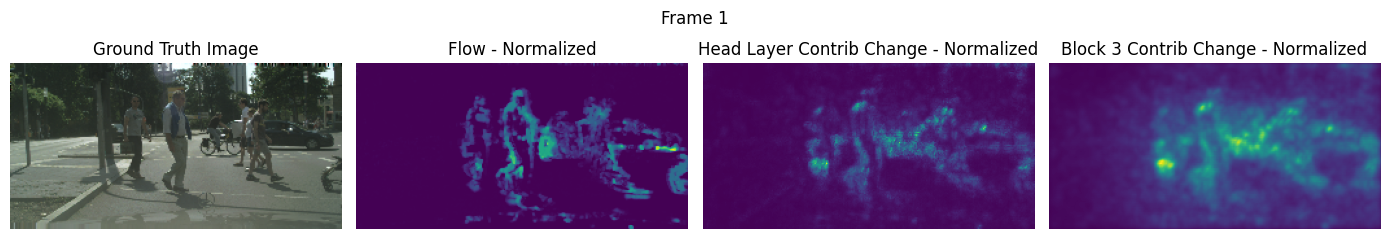

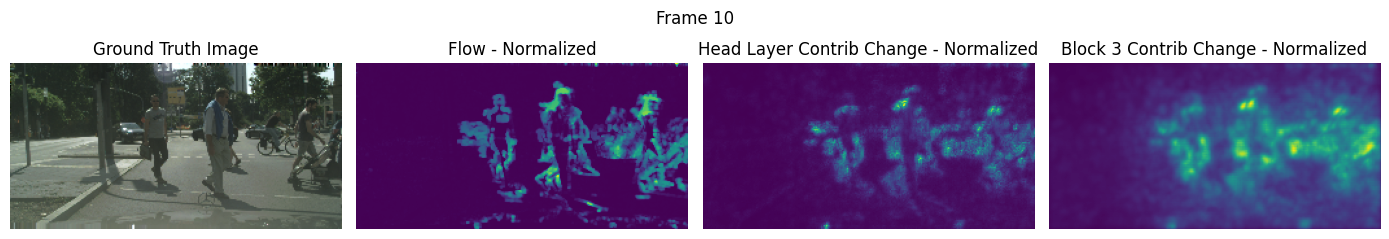

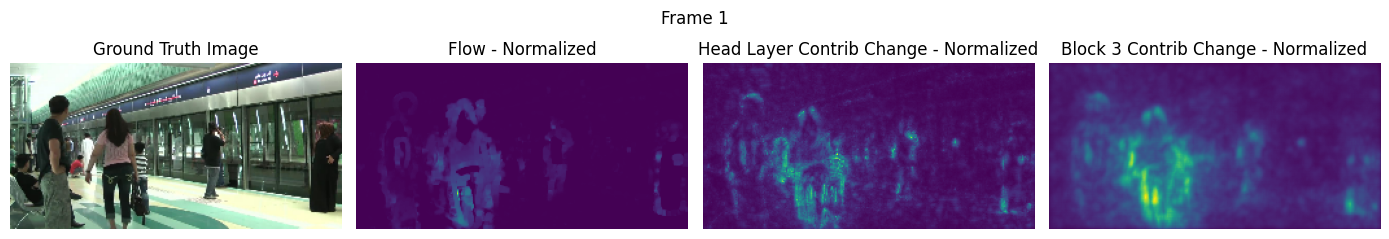

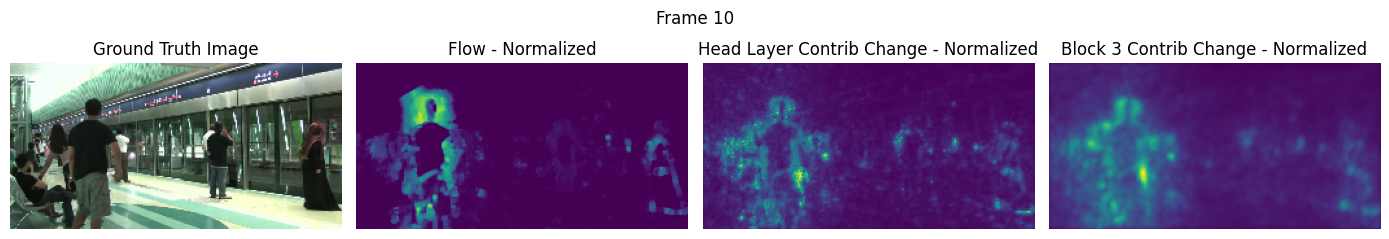

In [14]:
per_vid_optical_flow_dict = {}

for dataset_name in dataset_names:
    for vidname in vidnames[dataset_name]:
        if vidname in ["0175", "26_cblDl5vCZnw"]:
            train_dataloader = dataloader_dict[dataset_name][vidname]
            model = models_dict[dataset_name][vidname]
            args = args_dict[dataset_name][vidname]

            inference_results = flow_compute_inference_results(
                args, train_dataloader, model
            )
            plot_flow_and_fluctuation_maps(inference_results)

            per_vid_optical_flow_dict[vidname] = {
                "inference_results": inference_results
            }

In [15]:
import pickle

save_dir = "../analysis_data/NeRV/objects_and_motion"
os.makedirs(save_dir, exist_ok=True)

with open(os.path.join(save_dir, f"per_vid_optical_flow_dict.pkl"), "wb") as f:
    pickle.dump(per_vid_optical_flow_dict, f)